# Классическая свёрточная нейронная сеть LeNet-5

Сеть LeNet-5 была [представлена](https://www.researchgate.net/publication/2985446_Gradient-Based_Learning_Applied_to_Document_Recognition) в 1998 году и представляла из себя сеть из 2 свёрточных слоёв, 2 слоёв подвыборки и 3 полносвязных слоёв.\
Все свёртки были размером $5\times5$.\
Функция активации: *сигмоида* (ReLU ещё не придумали)\
Слои подвыборки: *усреднения*

![Lenet5](media/lenet5.svg "LeNeT-5")

In [1]:
import os
import struct
import numpy as np
import torch
from torch.nn import Module
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange

_ = torch.manual_seed(1)

In [2]:
class Model(Module):
    def __init__(self, activation):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.a1 = nn.Sigmoid() if activation == 'Sigmoid' else nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.a2 = nn.Sigmoid() if activation == 'Sigmoid' else nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.a3 = nn.Sigmoid() if activation == 'Sigmoid' else nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.a4 = nn.Sigmoid() if activation == 'Sigmoid' else nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.a5 = nn.GELU()
        

    def forward(self, x):
        y = self.conv1(x)
        y = self.a1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.a2(y)
        y = self.pool2(y)
#         y = y.view(y.shape[0], -1)  # взаимозаменяемо с nn.Flatten()
        y = self.flatten(y)
        y = self.fc1(y)
        y = self.a3(y)
        y = self.fc2(y)
        y = self.a4(y)
        y = self.fc3(y)
        y = self.a5(y)
        return y

![Gelu](media/gelu.png "GELU")

In [3]:
# Чтение данных из MNIST
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
mnist_root = 'media/MNIST'
files = {
    'train_images': os.path.join(mnist_root, 'train-images.idx3-ubyte'),
    'train_labels': os.path.join(mnist_root, 'train-labels.idx1-ubyte'),
    'test_images':os.path.join(mnist_root, 't10k-images.idx3-ubyte'),
    'test_labels':os.path.join(mnist_root, 't10k-labels.idx1-ubyte')
}
dataset = {}
for name, path in files.items():
    dataset[name] = read_idx(path)
    print(f'{len(dataset[name])} items in {name}')
    

60000 items in train_images
60000 items in train_labels
10000 items in test_images
10000 items in test_labels


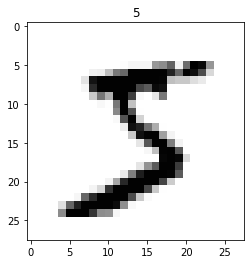

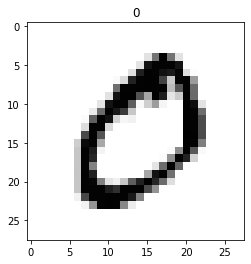

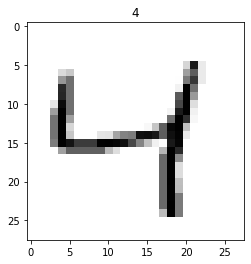

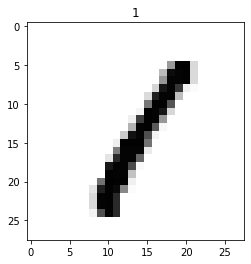

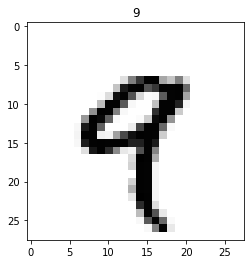

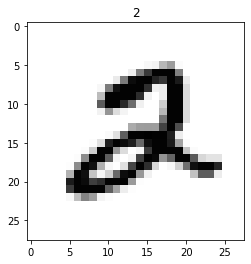

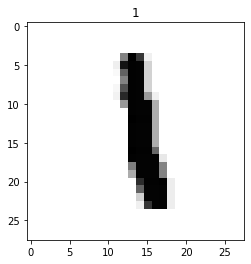

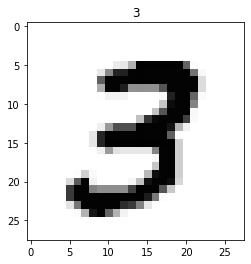

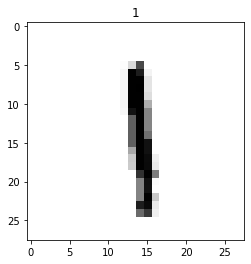

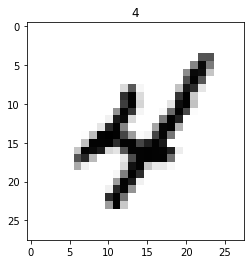

In [5]:
# Показ нескольких первых чисел
for i in range(10):
    plt.title(dataset['train_labels'][i])
    plt.imshow(dataset['train_images'][i], cmap='Greys')
    plt.show()
    # TODO: GRAY

In [6]:
# подготовка данных
train_mean = np.mean(dataset['train_images'])
train_std = np.std(dataset['train_images'])
print(train_mean, train_std)
dataset['train_images'] = (dataset['train_images'] - train_mean) / train_std

test_mean = np.mean(dataset['test_images'])
test_std = np.std(dataset['test_images'])
print(test_mean, test_std)
dataset['test_images'] = (dataset['test_images'] - train_mean) / train_std

train_label = torch.tensor(dataset['train_labels'], dtype=torch.long)
train_x = torch.tensor(dataset['train_images'], dtype=torch.float32).unsqueeze(1)
test_label = torch.tensor(dataset['test_labels'], dtype=torch.long)
test_x = torch.tensor(dataset['test_images'], dtype=torch.float32).unsqueeze(1)

33.318421449829934 78.56748998339798
33.791224489795916 79.17246322228644


<ipython-input-6-e876fb0cbc7b>:12: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  train_label = torch.tensor(dataset['train_labels'], dtype=torch.long)


In [51]:
def get_losshist_column(activation, optimizer, learning_rate):
    return f'{activation}_{optimizer}_lr{learning_rate}'

def log_loss(epoch, activation, optimizer, learning_rate, loss_history, loss):
    column = get_losshist_column(activation, optimizer, learning_rate)
    loss_history.loc[epoch, column] = loss
    

def get_optimizer(optim_name):
    optims = {
        'adam': Adam,
        'sgd': SGD
    }
    return optims[optim_name.lower()]

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        
def train_model(epochs, activation, optimizer_name, learning_rate, loss_history, log_dir, model_file=None):
#     print(f'Training model: {activation} {optimizer_name} lr={learning_rate} model file = {model_file}')
    
    if model_file:
        model = torch.load(model_file)
    else:
        model = Model(activation)
        model.apply(init_weights)
    
    optimizer = get_optimizer(optimizer_name)(model.parameters(), lr=learning_rate)
    
    cross_error = CrossEntropyLoss()
    t = trange(epochs)
    
    for e in t:
        t.set_description(f'Epoch {e+1}, {get_losshist_column(activation, optimizer_name, learning_rate)}')
        model.train()
        optimizer.zero_grad()
        predict_y = model(train_x) # для обучения используем весь пакет
        loss = cross_error(predict_y, train_label)
        loss_np = loss.detach().numpy()
        log_loss(e, activation, optimizer_name, learning_rate, loss_history, loss_np)
               
        loss.backward()
        optimizer.step()
        
        correct = 0
        _sum = 0
        model.eval()
        predict_y = model(test_x)
        predict_ys = torch.argmax(predict_y, axis=-1)
        matches = predict_ys == test_label
        correct += torch.sum(matches, axis=-1)
        _sum += matches.shape[0]
        accuracy = correct.numpy() / _sum
        t.set_postfix(loss=loss_np, accuracy=accuracy)
    torch.save(model,
               os.path.join(log_dir, f'lenet{activation}_{optimizer_name}_{learning_rate:.4f}.pth'))
    
    

Epoch 50, Sigmoid_SGD_lr10: 100%|█████████████████████| 50/50 [04:44<00:00,  5.68s/it, accuracy=0.0892, loss=2.3023922]


Final loss: ReLU_Adam_lr0.001      0.2711
ReLU_Adam_lr0.003      0.1473
ReLU_Adam_lr0.01       0.3143
ReLU_Adam_lr0.03       2.3029
ReLU_Adam_lr0.1        2.3020
ReLU_Adam_lr0.3        2.3029
ReLU_Adam_lr1          2.3029
ReLU_Adam_lr3          2.3029
ReLU_Adam_lr10         2.3029
ReLU_SGD_lr0.001       2.2946
ReLU_SGD_lr0.003       2.3020
ReLU_SGD_lr0.01        2.2280
ReLU_SGD_lr0.03        1.3425
ReLU_SGD_lr0.1         1.0630
ReLU_SGD_lr0.3         1.4689
ReLU_SGD_lr1           2.3014
ReLU_SGD_lr3           2.3019
ReLU_SGD_lr10             NaN
Sigmoid_Adam_lr0.001   2.2976
Sigmoid_Adam_lr0.003   2.2844
Sigmoid_Adam_lr0.01    2.3016
Sigmoid_Adam_lr0.03    2.3030
Sigmoid_Adam_lr0.1     2.3029
Sigmoid_Adam_lr0.3     2.3029
Sigmoid_Adam_lr1       2.3029
Sigmoid_Adam_lr3       2.3029
Sigmoid_Adam_lr10      2.3029
Sigmoid_SGD_lr0.001    2.3468
Sigmoid_SGD_lr0.003    2.3530
Sigmoid_SGD_lr0.01     2.3109
Sigmoid_SGD_lr0.03     2.3054
Sigmoid_SGD_lr0.1      2.3028
Sigmoid_SGD_lr0.3      2.301

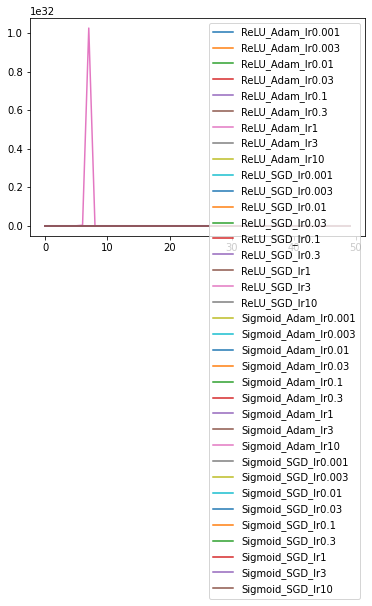

In [27]:
activations = ['ReLU', 'Sigmoid']
optimizers = ['Adam', 'SGD']
learning_rates = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1, 3, 10]

train_chedule = []
loss_hist_columns = []
for act in activations:
    for opt in optimizers:
        for lr in learning_rates:
            train_chedule.append({
                'activation': act,
                'optimizer': opt,
                'learning_rate': lr
            })
            loss_hist_columns.append(get_losshist_column(act, opt, lr))

epochs = 50
loss_history = pd.DataFrame(index=range(epochs), columns=loss_hist_columns, dtype=float)
log_dir = 'lenet_log'
os.makedirs(log_dir, exist_ok=True)
for params in train_chedule:
    train_model(epochs,
                params['activation'],
                params['optimizer'],
                params['learning_rate'],
                loss_history,
                log_dir)


pd.options.display.float_format = '{:.4f}'.format
print(f'Final loss: {loss_history.iloc[-1]}')
_ = loss_history.plot()
    

In [28]:
loss_history.to_pickle(os.path.join(log_dir, 'lenet_loss.pkl'))

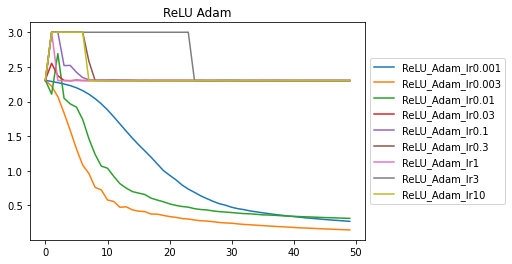

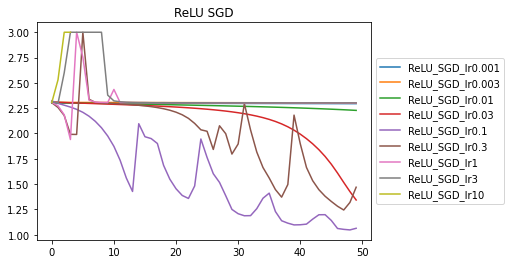

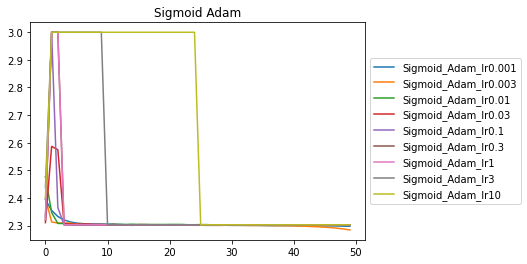

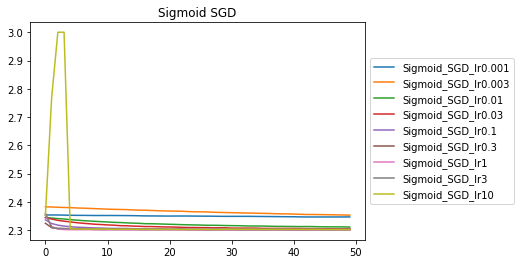

In [45]:
# Отрисуем ход обучения отдельно ReLU, отдельно Sigmoid
loss_history.head()
loss_history = pd.read_pickle(os.path.join(log_dir, 'lenet_loss.pkl'))
history_clipped = loss_history.clip(upper=3)  # умещаем всё в один масштаб
plot_step =int(len(train_chedule)/4)
relu_adam = history_clipped.iloc[:,0:plot_step]
relu_sgd = history_clipped.iloc[:,plot_step:2*plot_step]
sig_adam = history_clipped.iloc[:,2*plot_step:3*plot_step]
sig_sgd = history_clipped.iloc[:,3*plot_step:4*plot_step]

f = plt.figure()
plt.title('ReLU Adam', color='black')
relu_adam.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

f = plt.figure()
plt.title('ReLU SGD', color='black')
relu_sgd.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

f = plt.figure()
plt.title('Sigmoid Adam', color='black')
sig_adam.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

f = plt.figure()
plt.title('Sigmoid SGD', color='black')
sig_sgd.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [63]:
# Проверяем особые случаи, где был намёк на обучение с большим числом эпох
epochs = 150
variants = [{'activation': 'ReLU', 'optimizer': 'Adam', 'learning_rate': '0.00', 'lr': 0.003},
            {'activation': 'ReLU', 'optimizer': 'SGD', 'learning_rate': '0.10', 'lr': 0.1},
            {'activation': 'Sigmoid', 'optimizer': 'Adam', 'learning_rate': '0.00', 'lr': 0.003},
            {'activation': 'Sigmoid', 'optimizer': 'SGD', 'learning_rate': '10.00', 'lr': 10}]

loss_history_extra = pd.DataFrame(index=range(epochs), dtype=float)
log_dir_extra = os.path.join(log_dir, 'extra')
os.makedirs(log_dir_extra, exist_ok=True)

# Дообучение
for variant in variants:
    model_fname = os.path.join(log_dir, f"lenet{variant['activation']}_{variant['optimizer']}_{variant['learning_rate']}.pth")
    train_model(epochs,
                variant['activation'],
                variant['optimizer'],
                variant['lr'],
                loss_history_extra,
                log_dir_extra,
                model_fname)
loss_history_extra.to_pickle(os.path.join(log_dir_extra, 'lenet_loss_extra.pkl'))

Epoch 150, Sigmoid_SGD_lr10: 100%|██████████████████| 150/150 [13:45<00:00,  5.50s/it, accuracy=0.0892, loss=2.3031154]


TypeError: expected str, bytes or os.PathLike object, not DataFrame

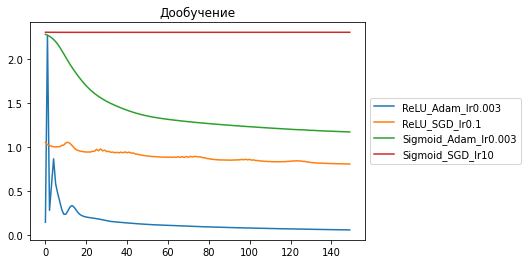

In [66]:
# Посмотрим, что дало дообучение
loss_history_load = pd.read_pickle(os.path.join(log_dir_extra, 'lenet_loss_extra.pkl'))
f = plt.figure()
plt.title('Дообучение', color='black')
loss_history_load.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [67]:
loss_history_extra

,ReLU_Adam_lr0.003,ReLU_SGD_lr0.1,Sigmoid_Adam_lr0.003,Sigmoid_SGD_lr10
0,0.1442,1.0507,2.2800,2.3034
1,2.2665,1.0262,2.2703,2.3030
2,0.2806,1.0180,2.2574,2.3030
3,0.5659,1.0065,2.2415,2.3029
4,0.8657,1.0049,2.2210,2.3030
...,...,...,...,...
145,0.0591,0.8083,1.1739,2.3031
146,0.0588,0.8078,1.1733,2.3031
147,0.0584,0.8074,1.1722,2.3032
148,0.0581,0.8070,1.1713,2.3031


In [70]:
#### Визуализация слоёв для лучшей сети
model = torch.load(os.path.join('lenet_log', 'extra', 'lenetReLU_Adam_0.0030.pth'))
model.eval()

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (a1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (a2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (a3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (a4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (a5): GELU()
)

In [71]:
no_of_layers=0
conv_layers=[]
model_children=list(model.children())

for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

2


In [119]:
def plot_kernels(tensor, num_cols=8):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

Layer  1
(1, 5, 5)
[[[ 0.19097878 -0.02615959 -0.16446604 -0.47814524 -0.3325633 ]
  [ 0.02775758  0.27880314 -0.03621094 -0.31698662 -0.23260434]
  [ 0.10169521  0.072575    0.18099135  0.17562379  0.12689969]
  [ 0.11938916  0.09389563  0.22281526  0.07228844 -0.16708761]
  [ 0.09205753  0.17188363 -0.10780885  0.12965192  0.07313935]]]


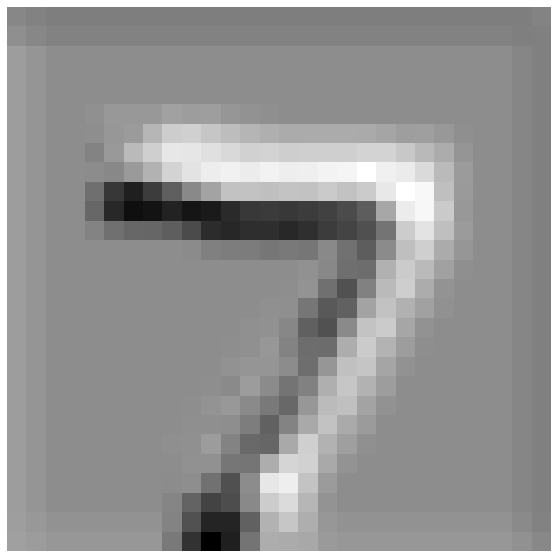

(1, 5, 5)
[[[-0.08964329 -0.0224838  -0.35156375 -0.30323178 -0.2861961 ]
  [-0.22429682 -0.27377033 -0.02397063 -0.18817225  0.06009555]
  [ 0.09245409  0.19368172  0.10717142  0.00763337 -0.01401248]
  [ 0.06494548  0.04163385  0.2167954   0.13394931  0.14141878]
  [ 0.14829838  0.21938527  0.09910054  0.16593847  0.1973072 ]]]


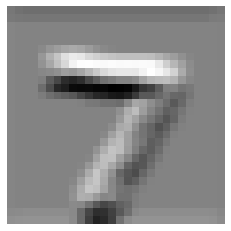

(1, 5, 5)
[[[-0.08528677 -0.10132867  0.05147586  0.15220454 -0.03135887]
  [-0.16835952 -0.00712203  0.210577    0.08795609 -0.16953821]
  [-0.03094338 -0.11081092  0.10822281  0.13125363 -0.12346292]
  [ 0.02380901 -0.04757466  0.21341623 -0.06277362  0.14971454]
  [-0.0734119   0.24556674  0.15391894  0.20817345  0.03471296]]]


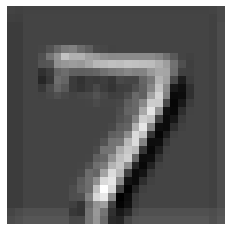

(1, 5, 5)
[[[-0.07299677 -0.18024883  0.03268858  0.06995596 -0.00486712]
  [ 0.14582762  0.01293851  0.11186058  0.10649484  0.10869908]
  [ 0.1894212   0.18436679  0.13689016  0.09712141 -0.07461881]
  [-0.03731942  0.07504764  0.05633381  0.07893023  0.06459171]
  [ 0.07050385 -0.10393272 -0.07816613  0.04287187  0.00063976]]]


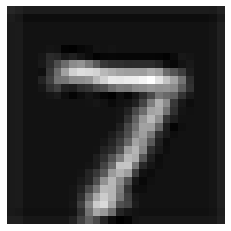

(1, 5, 5)
[[[-0.17820647  0.04999113  0.09221783  0.08379552 -0.0725778 ]
  [-0.12413746  0.09294076  0.09715194 -0.05770694  0.00231112]
  [-0.17308894  0.11996563  0.16433166  0.05681946  0.14348899]
  [ 0.11341612  0.01155834  0.11879048  0.1129934  -0.14033194]
  [-0.12724783  0.11716261  0.09224737  0.13304782  0.05446288]]]


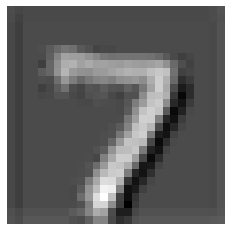

(1, 5, 5)
[[[ 0.04814268  0.139008    0.12841554  0.15207234 -0.15668589]
  [ 0.20682624  0.08765201  0.08179931 -0.07173223  0.06871866]
  [ 0.19807643 -0.05515897  0.09344084  0.19623104  0.07681296]
  [ 0.08248788 -0.00795517  0.12003622 -0.22575234 -0.1875205 ]
  [-0.08037633 -0.12351799 -0.02497067 -0.05693511 -0.20075616]]]


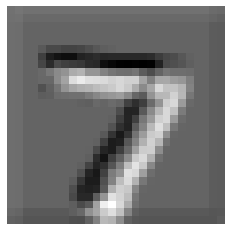

Layer  2
(6, 5, 5)
[[[ 0.17737569 -0.06524301 -0.19421898  0.01859682 -0.05841552]
  [ 0.10886009 -0.20459129 -0.19887288 -0.04712459  0.08766203]
  [-0.01936839 -0.02848264  0.02242539  0.09323876  0.08807605]
  [-0.06794906 -0.05439196  0.02255631  0.09715037  0.00560648]
  [-0.01789474 -0.11158128  0.05608065  0.10869271  0.11802257]]

 [[ 0.05994156 -0.10610903  0.00960243 -0.09265517  0.08341455]
  [ 0.0212668  -0.01236855  0.08023479 -0.05074056  0.04323593]
  [-0.02151673  0.00756173 -0.10189582  0.02314852 -0.0188256 ]
  [-0.01716652 -0.02165146 -0.0431716  -0.06232365  0.00898862]
  [-0.00052803 -0.09490946 -0.00583423 -0.11647627  0.03701612]]

 [[ 0.08695827 -0.16005726 -0.0435375   0.1103528   0.06877308]
  [-0.02405065 -0.14667217  0.1691859   0.16387007 -0.05711525]
  [-0.16954164 -0.0618804   0.01678463  0.11417259 -0.02028589]
  [-0.01376048  0.11212406  0.03773542  0.05210303 -0.12235653]
  [ 0.10063356  0.03702424  0.10753699  0.09662743  0.05816925]]

 [[-0.06751291 

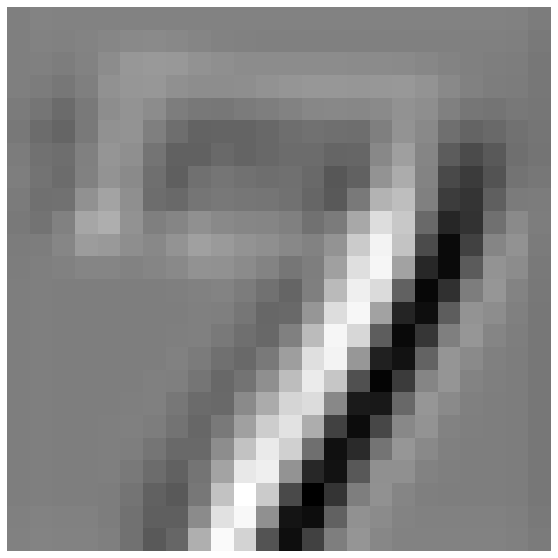

(6, 5, 5)
[[[-4.60999757e-02  2.11115684e-02  1.00950733e-01  5.34860604e-02
    7.76397884e-02]
  [ 1.42163545e-01  1.31102771e-01  1.07678458e-01  1.01084784e-01
    8.33441913e-02]
  [ 2.56648101e-02 -6.79608956e-02  1.38170421e-01  1.33709610e-01
    1.01865791e-01]
  [-1.13128908e-01 -3.98111120e-02 -2.33811978e-03  1.50365770e-01
    5.49286418e-02]
  [ 1.42911702e-01  7.66374990e-02 -2.19080955e-01 -5.60495779e-02
    1.26165122e-01]]

 [[ 1.82143822e-02  2.00375438e-01  1.37194976e-01  5.01255505e-02
   -9.30327456e-03]
  [ 3.58528085e-03  1.88205853e-01  7.37595633e-02 -7.14910179e-02
   -3.45351100e-02]
  [-9.58310217e-02 -2.22932063e-02 -6.09028004e-02 -1.12497702e-01
    1.90595048e-03]
  [-4.48443294e-02 -1.15555145e-01 -1.57705948e-01 -1.70007888e-02
    3.78798917e-02]
  [ 2.76525229e-01  1.08405970e-01 -5.93045652e-02 -1.26879945e-01
   -9.31285992e-02]]

 [[ 7.44248852e-02 -1.37863606e-02 -6.32210774e-03 -6.04010113e-02
    1.79048926e-02]
  [ 2.76255496e-02  7.5751833

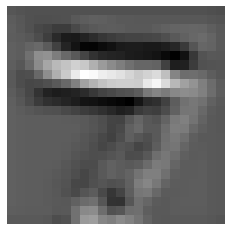

(6, 5, 5)
[[[-0.09782922 -0.06659994  0.0878708   0.178367    0.12649295]
  [ 0.05529702 -0.03448276  0.14608411  0.21269642  0.10971829]
  [ 0.03589593 -0.06178961 -0.03819811  0.17910048  0.1521955 ]
  [-0.02051263 -0.06375013 -0.0289872   0.0251421  -0.11735934]
  [-0.08693384  0.02072748  0.01989037 -0.04175001 -0.13736516]]

 [[-0.05555017 -0.05812257 -0.07670548  0.10788392 -0.00409675]
  [-0.04363464  0.06163589 -0.07602296  0.09144787  0.06373542]
  [ 0.1488203   0.06682225  0.09615526  0.01516653  0.04149071]
  [-0.0219673  -0.09680279 -0.05845542  0.047124   -0.05783712]
  [-0.11624636 -0.1294749   0.05525126  0.13660188  0.03082472]]

 [[ 0.02259293  0.08847032  0.04352216  0.13840641  0.05295942]
  [-0.01563437  0.10066875  0.08619662  0.11136441  0.03974945]
  [ 0.01385205 -0.00404303 -0.01081106  0.06431268  0.03116859]
  [-0.11680561  0.00446677 -0.10234079 -0.14904551 -0.08950242]
  [-0.101349    0.00274727 -0.0741252  -0.01792774  0.05397115]]

 [[-0.08121484  0.018048

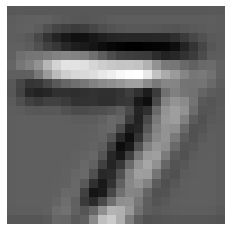

(6, 5, 5)
[[[ 2.21748766e-03 -1.70637131e-01 -1.29807562e-01  1.40564963e-02
   -7.73733854e-02]
  [-1.22057097e-02  5.22746891e-02 -4.56098653e-02 -4.63536531e-02
   -2.93973386e-02]
  [ 5.30761816e-02 -2.66096480e-02 -4.60195821e-03  7.55668879e-02
    1.94315892e-02]
  [-3.76016460e-02  3.13485526e-02 -2.67236400e-02  1.10884696e-01
    1.06764615e-01]
  [ 2.35435814e-02 -1.05759189e-01 -7.11198300e-02 -9.77708548e-02
    1.27270730e-04]]

 [[ 5.07340953e-02 -8.21055323e-02  7.08994791e-02 -1.18402779e-01
   -1.57825381e-01]
  [-5.69548868e-02  1.00152746e-01 -3.41215692e-02  3.77550907e-02
   -1.12731069e-01]
  [ 5.46393879e-02 -5.69741502e-02  7.28394315e-02 -5.28221279e-02
    2.61724163e-02]
  [-4.26936522e-02  1.86739117e-02 -2.85152290e-02  6.85511678e-02
   -9.55252443e-03]
  [-3.66818085e-02 -9.54760145e-03 -1.52542695e-01 -5.72209880e-02
   -1.06229439e-01]]

 [[-9.35157165e-02  1.04683779e-01  1.18131556e-01 -3.67009901e-02
    1.90819297e-02]
  [-5.69083057e-02  7.3257505

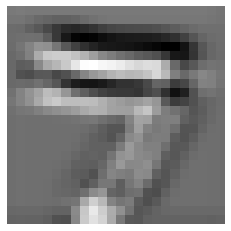

(6, 5, 5)
[[[ 0.01196082 -0.02211331 -0.03323909  0.07066268 -0.12686735]
  [-0.140046   -0.12915297  0.11523497  0.00716835 -0.09281599]
  [-0.02984326 -0.00481604  0.07807142  0.05492569 -0.06215366]
  [ 0.04583266  0.10829666  0.17315644  0.07638694  0.07639231]
  [-0.05166648  0.077352    0.09480006  0.21235235  0.19286968]]

 [[-0.02999494 -0.12310614 -0.08555149 -0.05614648  0.0288571 ]
  [-0.01709637 -0.13605885 -0.12655734 -0.11834516  0.03755588]
  [-0.11755825 -0.14564757  0.01679804 -0.01558482 -0.0535306 ]
  [-0.12150491 -0.17967951  0.00999753  0.12261426 -0.06185282]
  [-0.04996142 -0.11399729  0.03562615  0.11249144  0.02535568]]

 [[-0.07852412  0.09457348  0.18466488 -0.10375184 -0.05089418]
  [-0.02021801  0.13527119  0.01054327 -0.0068316   0.00823223]
  [ 0.10115689  0.05862958 -0.02261835  0.00381426 -0.13947096]
  [-0.00703357  0.01410639  0.14116389  0.05859859 -0.13962756]
  [ 0.10357258  0.11554115 -0.03348906  0.00836267 -0.12604605]]

 [[-0.10212588  0.013522

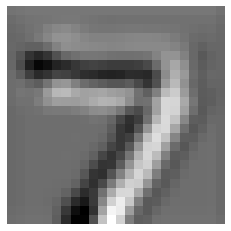

(6, 5, 5)
[[[-1.32653806e-02  1.72042783e-04 -4.82556634e-02 -5.51542491e-02
   -6.13953248e-02]
  [ 1.91073418e-02  7.78851882e-02  1.15872838e-01  8.00948143e-02
   -3.68575081e-02]
  [-1.59759820e-02  1.45352900e-01  1.74686357e-01  8.23930055e-02
    4.22200896e-02]
  [ 5.30300923e-02  4.98504704e-03  8.94445553e-02  3.77438664e-02
    8.13732669e-02]
  [-6.71995757e-03 -1.01256430e-01 -4.30497946e-03 -1.59024253e-01
   -1.01543210e-01]]

 [[-2.69927569e-02 -1.02444649e-01 -8.47981200e-02 -6.03107177e-02
   -9.83913839e-02]
  [-3.33654806e-02  6.83374926e-02 -4.21602353e-02  1.35810539e-01
    1.00472271e-01]
  [ 1.24936923e-01  1.93961620e-01  5.80502376e-02  1.33614868e-01
    2.33542752e-02]
  [ 8.76779668e-03  1.14136882e-01 -4.69759898e-03  4.50132936e-02
   -7.64559116e-03]
  [-1.08875632e-01 -1.63770914e-01 -1.15369536e-01  3.29716131e-03
    7.09232986e-02]]

 [[ 1.43208704e-03 -7.62923285e-02 -6.74287230e-02 -6.19805716e-02
   -3.30196656e-02]
  [ 1.24653280e-02  4.0118500

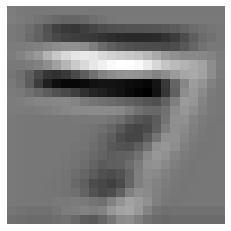

(6, 5, 5)
[[[ 0.00261901  0.08974715 -0.06961609  0.08690775 -0.01015251]
  [-0.08913364  0.11435258  0.10285869 -0.06461012  0.05687593]
  [ 0.03830601  0.01800727  0.0033819   0.09249184  0.0478823 ]
  [-0.05897134 -0.041062    0.0007989   0.05901502  0.07766733]
  [-0.08723389  0.00807753  0.10071932 -0.03137524 -0.00252401]]

 [[ 0.00785801 -0.00201995 -0.06607537 -0.09384955 -0.13099949]
  [-0.0162663  -0.03536779 -0.10531415 -0.05396863  0.00706419]
  [ 0.00151941  0.05360813 -0.08537681  0.01392649 -0.11355499]
  [ 0.04094993  0.00568257 -0.09943981  0.02957483 -0.08206601]
  [ 0.07441892 -0.0820885  -0.04969548  0.12663409  0.00758019]]

 [[ 0.066393    0.11021871  0.09881604  0.09030114  0.03155824]
  [ 0.05902781 -0.04597441  0.13051149  0.02301887 -0.10560468]
  [ 0.12360951  0.02760583  0.1342485  -0.05964951 -0.00187095]
  [-0.00370427 -0.05899158  0.02062313 -0.08457679 -0.01558077]
  [-0.0864896   0.00254593 -0.02252886  0.00070139 -0.08553164]]

 [[ 0.00026256 -0.024734

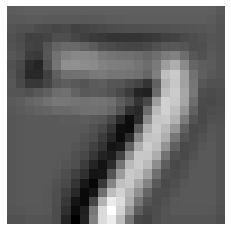

(6, 5, 5)
[[[ 0.07506081  0.10011587  0.08281823  0.02711852  0.147865  ]
  [-0.09713741 -0.13889511  0.0059581   0.06300099  0.04630219]
  [ 0.034102   -0.00203927 -0.06769688 -0.00583261  0.01796835]
  [ 0.08549768 -0.12040987  0.10540016  0.06655577 -0.04802134]
  [-0.03646765  0.04137603  0.08784719 -0.04865092 -0.13244478]]

 [[ 0.07467724 -0.05958578  0.05365237  0.02661131  0.1317287 ]
  [-0.24329147 -0.0340864  -0.04817363 -0.13478386 -0.08936341]
  [-0.09258155 -0.04361344  0.15592039 -0.01299654 -0.03114937]
  [-0.02338021  0.0072738   0.05054798 -0.0777801  -0.02770751]
  [-0.05930642 -0.04777561  0.02877714  0.00071047  0.04467671]]

 [[ 0.08897589 -0.0713165  -0.02649781 -0.05885455  0.06779402]
  [-0.12403293 -0.04342813 -0.10029063 -0.07229057 -0.05280633]
  [-0.12741908 -0.04463813 -0.08817429  0.01912667  0.01171744]
  [-0.10171536  0.06932256 -0.01396075  0.07599249  0.07929306]
  [ 0.01286667  0.09148899  0.14435168 -0.07908314 -0.01193453]]

 [[ 0.0887696   0.081402

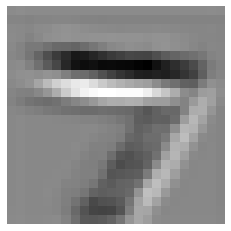

(6, 5, 5)
[[[ 0.13932112  0.03610817  0.06646903  0.04941081 -0.01503895]
  [ 0.01507403 -0.0325741  -0.08657701 -0.08490132 -0.01316038]
  [-0.0187139  -0.01710271 -0.02358384  0.09224495 -0.02002043]
  [-0.03583545 -0.02838522 -0.01926788 -0.020693    0.05144601]
  [-0.02271687 -0.03873039  0.00529321 -0.12076298  0.06725945]]

 [[ 0.11736203  0.01122966  0.14510898  0.1000377  -0.09695946]
  [ 0.02477617 -0.06073735 -0.07175207  0.04326313  0.02881475]
  [ 0.09194584  0.06663974  0.06759363  0.0899398   0.13254943]
  [ 0.12890859  0.11671127  0.15697525  0.09344646  0.0561234 ]
  [ 0.02462943  0.02065581  0.03542493 -0.0267636  -0.04620523]]

 [[ 0.07521953 -0.02855173 -0.06382841 -0.03208767 -0.12587623]
  [-0.00419152 -0.06102193 -0.09335904 -0.06266142 -0.08163606]
  [ 0.08374301  0.10225431  0.09229301  0.07665158  0.08159579]
  [ 0.05948122 -0.03064865  0.07379696 -0.00427947 -0.06501792]
  [-0.14210783 -0.17558943 -0.15101622 -0.12558503  0.0217611 ]]

 [[-0.04041387  0.035455

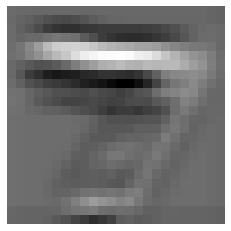

(6, 5, 5)
[[[-1.31450519e-01 -2.42790710e-02 -9.02296901e-02 -1.09703332e-01
    2.45980658e-02]
  [ 2.12483294e-02 -1.18156746e-01 -5.94371147e-02 -1.33108541e-01
   -9.83011201e-02]
  [-1.78903099e-02  6.77192817e-03  3.89684550e-02 -1.53753778e-03
   -5.92993051e-02]
  [ 1.19455561e-01  5.64300045e-02 -8.39297287e-03 -5.67726269e-02
   -5.91431372e-02]
  [-3.72330137e-02  1.48895755e-01  1.10625580e-01  1.03168413e-01
    1.02436341e-01]]

 [[-6.33625314e-02 -6.08808398e-02  3.53090618e-05  3.32548432e-02
   -1.34003460e-01]
  [-5.02000563e-02  3.78269590e-02 -1.63702071e-01 -3.38689312e-02
    1.88652966e-02]
  [ 9.35036168e-02  6.10208176e-02 -1.76970661e-02  1.11465633e-01
    1.72999308e-01]
  [ 1.08133994e-01  1.23280957e-01  1.36260316e-01  2.66850996e-03
    1.12458587e-01]
  [-3.63126397e-02  3.80879492e-02 -2.10842714e-02  1.96282044e-02
    5.88861257e-02]]

 [[-3.08020543e-02 -1.11078881e-01 -1.35425672e-01 -1.25046238e-01
   -1.13091961e-01]
  [-3.72312143e-02  5.5612284

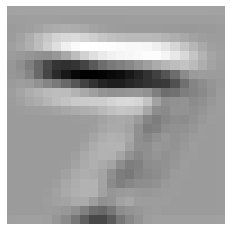

(6, 5, 5)
[[[-0.09365842 -0.04399523  0.07327424  0.04937197 -0.09809599]
  [ 0.03541567 -0.06014692  0.00864281 -0.08406619 -0.13632728]
  [-0.10316993 -0.07966039 -0.02428312 -0.01737398 -0.14055589]
  [-0.17015314 -0.0696367   0.08159765 -0.14405023 -0.140423  ]
  [-0.05754439  0.03027546  0.08844999 -0.11288999 -0.00164977]]

 [[ 0.03816818  0.04883001 -0.04597631 -0.11020538 -0.12492651]
  [ 0.09181096  0.00304981 -0.01632604 -0.05413022 -0.1284639 ]
  [ 0.0672637   0.01584899 -0.18693297 -0.14730047 -0.02895716]
  [-0.12677157 -0.05115821 -0.15931687 -0.05450079  0.16006222]
  [-0.12111092 -0.10655405  0.09874389  0.11803535  0.12375981]]

 [[ 0.03919431 -0.01229844  0.1143902  -0.01855752  0.02486993]
  [-0.03832961  0.11182828  0.04186273 -0.0884942  -0.00946207]
  [ 0.11388838  0.19482392 -0.0938611  -0.13334724  0.17820263]
  [ 0.1262692  -0.00039383 -0.08506616 -0.02986735  0.03737944]
  [ 0.09270562  0.11662987 -0.12029192  0.1729001   0.13684255]]

 [[ 0.05617996  0.053885

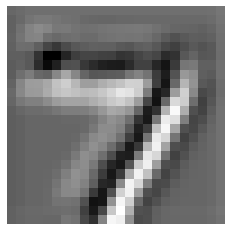

(6, 5, 5)
[[[ 4.31636907e-02  5.20555787e-02  5.46227917e-02 -9.47605297e-02
    1.22457221e-01]
  [-2.82524955e-02  4.04231660e-02 -1.33246467e-01 -5.37241101e-02
    1.22612096e-01]
  [-5.75084165e-02 -8.77869222e-03 -9.22650620e-02  6.23445846e-02
    1.02124684e-01]
  [ 3.03101391e-02  1.98994484e-02  7.85542801e-02  1.27841473e-01
   -1.88296419e-02]
  [ 3.86092626e-02  7.17668533e-02  7.39632919e-02  7.68548697e-02
   -1.43654598e-02]]

 [[-8.30364898e-02  3.89257818e-02  1.65178422e-02  2.37962324e-02
   -3.00268978e-02]
  [-4.57582809e-02  4.98002321e-02 -9.15339291e-02 -1.02197446e-01
   -7.95965567e-02]
  [-1.05506644e-01 -3.02368663e-02  7.33773932e-02  1.26614037e-03
    1.59356426e-02]
  [-4.26049381e-02 -6.46880642e-02  1.48694918e-01  1.63383290e-01
    1.68982089e-01]
  [-9.56391767e-02  1.31862089e-02  9.52519476e-02  1.17716022e-01
    1.22252427e-01]]

 [[ 1.22854531e-01 -7.22835734e-02 -7.26667792e-02  1.11420847e-01
    8.82294327e-02]
  [ 2.75850706e-02  7.1471981

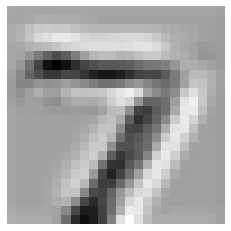

(6, 5, 5)
[[[-0.06561537  0.01153005 -0.19299753 -0.05878796 -0.04860345]
  [ 0.02173817 -0.1470431  -0.1966555  -0.11002189  0.00029183]
  [ 0.05773636 -0.07773232  0.04012584  0.13102873  0.12297584]
  [ 0.07744904 -0.01494851 -0.04969477  0.04527584 -0.03465961]
  [ 0.11645839 -0.09638333  0.13283363  0.07478996 -0.05663521]]

 [[-0.03716048 -0.00801838 -0.06755481 -0.07992861  0.04113988]
  [-0.06783713  0.13369009  0.02012343 -0.0962574  -0.02623788]
  [-0.03482829 -0.02329168 -0.09532075 -0.09987298  0.03473347]
  [ 0.0018812  -0.07035404 -0.10040263  0.13114667  0.13087049]
  [ 0.08618946  0.08116424 -0.0389622   0.15836278  0.12556465]]

 [[-0.05491004 -0.03862486 -0.00676229  0.11290658  0.03933579]
  [ 0.04068264 -0.03111554  0.15032499  0.07108083  0.02604672]
  [-0.01717075  0.10038635  0.11161508 -0.08205488 -0.13823253]
  [ 0.0199972   0.08508378 -0.06621029  0.01507304  0.03800049]
  [ 0.04614535  0.05927467 -0.02721111 -0.09572356 -0.00449842]]

 [[-0.08317524 -0.019186

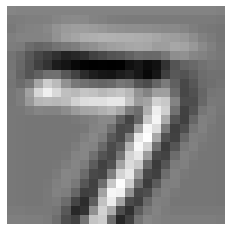

(6, 5, 5)
[[[-0.082399   -0.02943372 -0.11120032 -0.11290684  0.06347191]
  [-0.14303927 -0.08340541 -0.01543769  0.0705279  -0.0422161 ]
  [ 0.02512023  0.06558835  0.07616118  0.08966543  0.04112116]
  [-0.04866935  0.07875577 -0.03702222  0.10869304 -0.0596798 ]
  [ 0.01822454  0.03296437  0.03924222  0.02299555  0.02092995]]

 [[-0.02671723  0.09642963  0.07506031  0.07637491  0.12661834]
  [ 0.03904698 -0.09842599  0.10166154 -0.05333718 -0.02864949]
  [ 0.06510792  0.02518512  0.00876605 -0.07031026 -0.03898498]
  [ 0.07004245  0.09683317 -0.02059724 -0.05988034  0.02739159]
  [-0.12717888 -0.00060203 -0.08288679 -0.08756775 -0.03744069]]

 [[-0.13150686  0.0262764   0.05441611 -0.07443006 -0.02801782]
  [-0.04495785 -0.09457627 -0.08174521  0.04965512 -0.08396797]
  [-0.02754827  0.03272248 -0.07220585  0.0056936  -0.10503725]
  [ 0.02991881  0.08669484 -0.09403723 -0.00704289  0.04761336]
  [-0.08244632  0.04849975  0.04864232 -0.04222318 -0.06115617]]

 [[-0.14982294 -0.082339

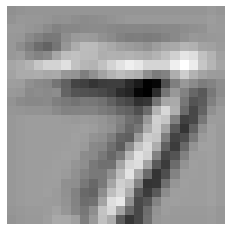

(6, 5, 5)
[[[-0.04767318  0.08385707  0.11828507  0.06548903  0.10136069]
  [ 0.03230121  0.00070014  0.12629181  0.10054971 -0.04364024]
  [ 0.05919894 -0.01700642 -0.08696898  0.09835085  0.00230962]
  [-0.00868428 -0.09777176 -0.01868918  0.14704326  0.08338601]
  [-0.05685626  0.03573712  0.12979516 -0.0029068   0.05974228]]

 [[ 0.05999631 -0.0468473   0.05810098  0.09141221  0.00020002]
  [ 0.03795033  0.11579771 -0.0236532   0.05517744 -0.10110757]
  [ 0.01776787  0.07920317 -0.03982186  0.00641646  0.02549621]
  [ 0.07611777  0.08184587  0.0992645   0.02207316 -0.07783614]
  [-0.01034702 -0.03726183  0.00081827 -0.01426378 -0.06672822]]

 [[-0.0486154   0.00469451 -0.0681731  -0.01233375 -0.0721335 ]
  [ 0.0522613   0.00772331 -0.00412341 -0.01021447 -0.03640338]
  [-0.04096338 -0.07120344  0.09226397  0.00809224  0.0452752 ]
  [ 0.0619748   0.09013417  0.12832578  0.03941906  0.08848765]
  [-0.02462845  0.03865574 -0.01798327  0.09099106 -0.07725969]]

 [[-0.02980203 -0.011350

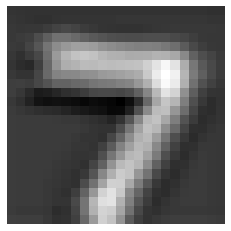

(6, 5, 5)
[[[-4.78288271e-02 -1.89008832e-01 -1.23297393e-01  6.44217357e-02
    6.44131983e-03]
  [-4.40890938e-02 -7.26808235e-02 -1.07573263e-01  4.20761257e-02
    3.68789099e-02]
  [ 2.85380520e-02 -8.80535841e-02 -7.60105029e-02  8.13563615e-02
   -5.91612654e-03]
  [ 4.23967354e-02  4.34798300e-02  1.18310936e-01  9.62026194e-02
   -4.62399144e-03]
  [-2.13931892e-02 -3.88614722e-02  1.33466840e-01  2.14802753e-02
    6.52156845e-02]]

 [[ 3.75942327e-05 -3.77032943e-02 -6.85831532e-02 -1.08948737e-01
    3.76064628e-02]
  [ 9.77571011e-02  7.91814551e-03  4.89810333e-02  8.17548949e-03
    6.22089878e-02]
  [ 3.95161733e-02  3.63548356e-03  4.15264571e-04 -7.78639168e-02
   -1.10465288e-01]
  [-4.37097847e-02 -1.38118014e-01 -1.05905928e-01 -3.88609655e-02
   -1.64336469e-02]
  [-1.25971241e-02  6.03308901e-03 -5.44525608e-02  3.76342535e-02
    7.93277919e-02]]

 [[-1.17776245e-01  6.80679083e-02  1.24695197e-01  1.23913720e-01
    7.77043924e-02]
  [ 1.73273776e-02 -3.5822726

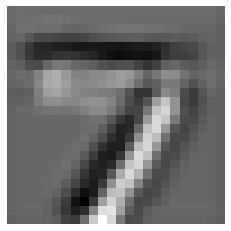

In [131]:
for i in range(1):
    results = [conv_layers[0](test_x[i,:,:,:].unsqueeze(0))]
    for i in range(1, len(conv_layers)):
        results.append(conv_layers[i](results[-1]))
        weights.append(conv_layers[i].weight)
    outputs = results
    for num_layer in range(len(outputs)):
        plt.figure(figsize=(50, 10))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        print("Layer ",num_layer+1)
        for i, filter in enumerate(layer_viz):
            if i == 16: 
                break
            weight = conv_layers[num_layer].weight[i].detach().numpy()
            print(weight.shape)
            print(weight)
#             plt.subplot(2, 8, i + 1)
            plt.imshow(filter, cmap='gray')
            plt.axis("off")
            plt.show()
#         plt.show()
        plt.close()

In [90]:
print(conv_layers[0].weight[0])

tensor([[[ 0.1910, -0.0262, -0.1645, -0.4781, -0.3326],
         [ 0.0278,  0.2788, -0.0362, -0.3170, -0.2326],
         [ 0.1017,  0.0726,  0.1810,  0.1756,  0.1269],
         [ 0.1194,  0.0939,  0.2228,  0.0723, -0.1671],
         [ 0.0921,  0.1719, -0.1078,  0.1297,  0.0731]]],
       grad_fn=<SelectBackward>)


In [118]:
len(conv_layers[num_layer].weight[0]

tensor([[[[ 1.7738e-01, -6.5243e-02, -1.9422e-01,  1.8597e-02, -5.8416e-02],
          [ 1.0886e-01, -2.0459e-01, -1.9887e-01, -4.7125e-02,  8.7662e-02],
          [-1.9368e-02, -2.8483e-02,  2.2425e-02,  9.3239e-02,  8.8076e-02],
          [-6.7949e-02, -5.4392e-02,  2.2556e-02,  9.7150e-02,  5.6065e-03],
          [-1.7895e-02, -1.1158e-01,  5.6081e-02,  1.0869e-01,  1.1802e-01]],

         [[ 5.9942e-02, -1.0611e-01,  9.6024e-03, -9.2655e-02,  8.3415e-02],
          [ 2.1267e-02, -1.2369e-02,  8.0235e-02, -5.0741e-02,  4.3236e-02],
          [-2.1517e-02,  7.5617e-03, -1.0190e-01,  2.3149e-02, -1.8826e-02],
          [-1.7167e-02, -2.1651e-02, -4.3172e-02, -6.2324e-02,  8.9886e-03],
          [-5.2803e-04, -9.4909e-02, -5.8342e-03, -1.1648e-01,  3.7016e-02]],

         [[ 8.6958e-02, -1.6006e-01, -4.3538e-02,  1.1035e-01,  6.8773e-02],
          [-2.4051e-02, -1.4667e-01,  1.6919e-01,  1.6387e-01, -5.7115e-02],
          [-1.6954e-01, -6.1880e-02,  1.6785e-02,  1.1417e-01, -2.0286e-